In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data

from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

# Uncertainty

## Types of uncertainty

### Epistemic uncertainty

### Aleatory uncertainty





# Some existing methods for modelling uncertainty

## Monte Carlo Dropout

## Distributional Parameter Learning

## Ensemble Averaging

## Dropout Ensembles

## Quantile Regression


# Uncertainty modelling example

## Function

$$ y_i = f(x_i) + \epsilon_i, \hspace{1cm} \epsilon_i \sim \mathcal{N}(0,\sigma^2)$$


In [14]:
N_SAMPLES = 200
SIGMA = 0.5  # Data standard deviation
BATCH_SIZE = 16
N_EPOCHS = 1000

In [5]:
np.random.seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# Data generating function
def f(x, sigma):
    y = 2 * np.sin(x + 0.5) + 3 * np.cos(0.7 * x) #  + (0.1 * x) ** 3
    eps = np.random.normal(loc=0, scale=sigma, size=x.shape)
    return y + eps

In [102]:
# Training data
x_1 = np.random.uniform(-12, -2, size=N_SAMPLES // 2)
x_2 = np.random.uniform(0, 10, size=N_SAMPLES // 2)
x_train = np.concatenate([x_1, x_2]).reshape(N_SAMPLES, 1)
y_train = f(x_train, sigma=SIGMA)

# Test data
x_test = np.random.uniform(-15, 15, size=40).reshape(40, 1)
y_test = f(x_test, sigma=SIGMA)

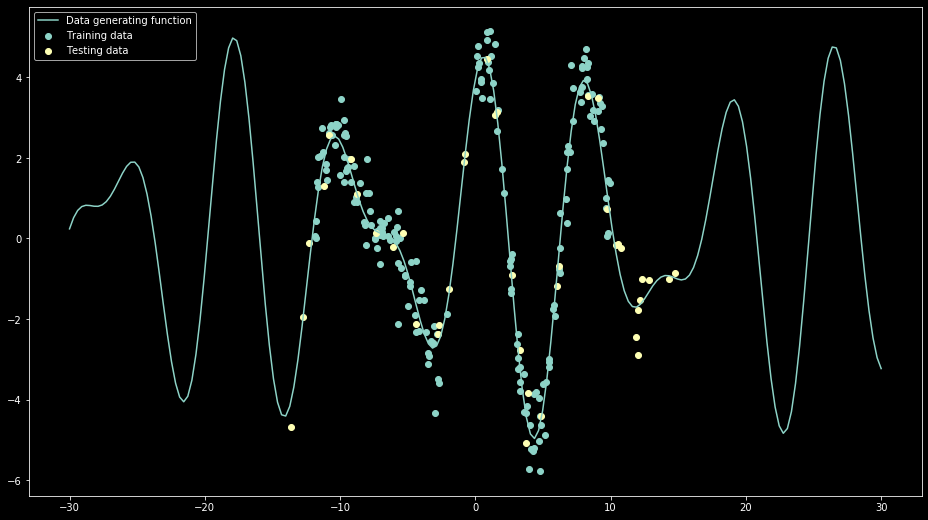

In [103]:
x_plot = np.linspace(-20, 20, num=200)
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.plot(x_plot_big, f(x_plot_big, sigma=0), label='Data generating function')
ax.scatter(x_train, y_train, label='Training data')
ax.scatter(x_test, y_test, label='Testing data')
ax.legend()

In [106]:
# Dataset and loader
dataset_train = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
dataset_test = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE)

In [107]:
def train(epoch, model, loss, optimizer, dataloader):
    model.train()
    total_loss = 0
    for i, (x_batch, y_batch) in enumerate(dataloader, start=1):
        x_batch.to(device)
        y_batch.to(device)
        optimizer.zero_grad()
        mu_pred, logvar_pred = model.forward(x_batch)
        loss_batch = loss(y_batch, mu_pred, logvar_pred)
        loss_batch.backward()
        optimizer.step()
        total_loss += loss_batch[0].item()

    return total_loss / i


def test(epoch, model, loss, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(dataloader, start=1):
            x_batch.to(device)
            y_batch.to(device)
            mu_pred, logvar_pred = model.forward(x_batch)
            loss_batch = loss(y_batch, mu_pred, logvar_pred)
            total_loss += loss_batch[0].item()

    return total_loss / i

## Distributional Parameter Learning

In [108]:
class GaussianNLLLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_true, mu_pred, logvar_pred):
        return torch.mean(logvar_pred / (2) + (mu_true - mu_pred).pow(2) / (2 * logvar_pred.exp()), axis=0)

In [109]:
class DPLModel(nn.Module):
    """Distributional Parameter Learning Model using Gaussian"""
    def __init__(self, dims=[1, 40, 40, 2], batchnorm=True):
        super().__init__()
        self.layers = []
        self.layers.append(nn.Linear(dims[0], dims[1]))
        for i in range(1, len(dims) - 1):
            elu = nn.ELU()
            lin = nn.Linear(dims[i], dims[i + 1])
            setattr(self, f'elu_{i}', elu)
            setattr(self, f'lin_{i}', lin)
            self.layers.append(elu)
            self.layers.append(lin)
            if batchnorm:
                bn = nn.BatchNorm1d(dims[i + 1])
                setattr(self, f'bn_{i}', bn)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        mu = x[..., 0:1]
        logvar = x[..., 1:2]
        return mu, logvar

In [110]:
# Initialize model parameters and setup
dpl_model = DPLModel()
dpl_model.to(device)
gaussian_nll_loss = GaussianNLLLoss()
gaussian_nll_loss.to(device)
optimizer = optim.Adam(dpl_model.parameters(), lr=1e-3)

In [111]:
for epoch in range(N_EPOCHS):
    train_loss = train(epoch, dpl_model, gaussian_nll_loss, optimizer, dataloader_train)
    test_loss = test(epoch, dpl_model, gaussian_nll_loss, dataloader_test)
    print(f'Epoch {epoch:3d} | Train loss {train_loss:2.3f} | Test loss {test_loss:2.3f}', end='\r')

Epoch 499 | Train loss 0.322 | Test loss 1.152

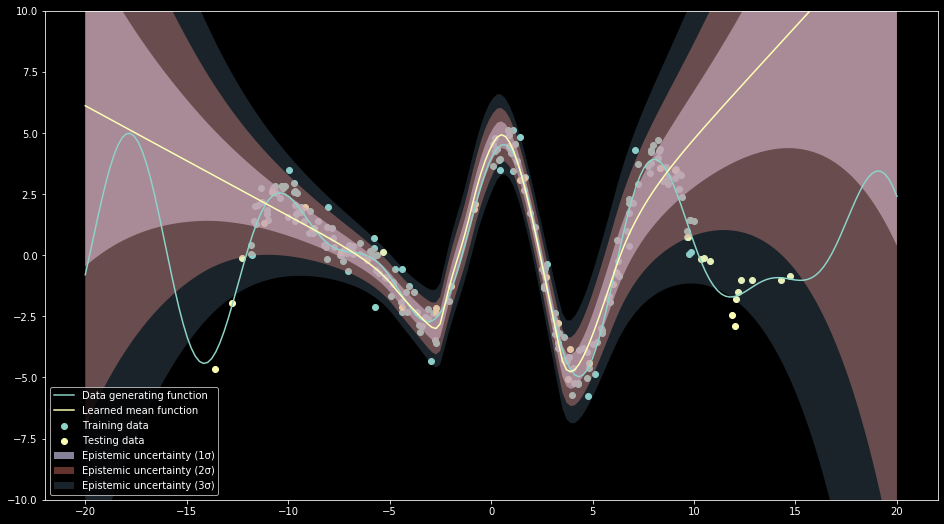

In [113]:
def plot_learned_function(model, x_data):
    with torch.no_grad():
        x_data_tensor = torch.Tensor(x_data.reshape(-1, 1))
        x_data_tensor.to(device)
        learned_function, epistemic_logvar = model.forward(x_data_tensor)
        learned_function = learned_function.flatten()
        epistemic_std = epistemic_logvar.flatten().exp().sqrt()

    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    ax.plot(x_data, f(x_data, sigma=0), label='Data generating function')
    ax.scatter(x_train, y_train, label='Training data')
    ax.scatter(x_test, y_test, label='Testing data')
    ax.plot(x_data, learned_function, label='Learned mean function')
    ax.fill_between(x_data, learned_function - 1 * epistemic_std, learned_function + 1 * epistemic_std, alpha=0.7, label='Epistemic uncertainty (1σ)')
    ax.fill_between(x_data, learned_function - 2 * epistemic_std, learned_function + 2 * epistemic_std, alpha=0.4, label='Epistemic uncertainty (2σ)')
    ax.fill_between(x_data, learned_function - 3 * epistemic_std, learned_function + 3 * epistemic_std, alpha=0.2, label='Epistemic uncertainty (3σ)')
    ax.set_ylim([-10, 10])
    ax.legend()

plot_learned_function(model, x_plot)